# Code of Group 12, TM10007: Project 4 - ECG

##Importeren

In [1]:
import zipfile
import pandas as pd
import numpy as np
import shutil
import subprocess
import shutil
import stat
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os import path
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn import model_selection
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, fbeta_score, make_scorer, fbeta_score, RocCurveDisplay
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, learning_curve, train_test_split, cross_val_predict, GridSearchCV, cross_validate, ShuffleSplit
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from scipy.stats import kstest

## if data.csv is not present download it from github
if not os.path.isfile("ecg_data.csv"):
    ## clone repo from githun
    if not os.path.isdir("tm10007_ml"):
        !git clone https://github.com/jveenland/tm10007_ml.git
    ## extract zip file
    if not os.path.isfile("tm10007_ml/ecg/ecg_data.csv"):
        with zipfile.ZipFile('tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
            zip_ref.extractall('tm10007_ml/ecg')
    ## move data file to root folder
    shutil.move('tm10007_ml/ecg/ecg_data.csv', 'ecg_data.csv')

    ## Delete cloned repo
    for root, dirs, files in os.walk("./tm10007_ml"):  
        for dir in dirs:
            os.chmod(path.join(root, dir), stat.S_IRWXU)
        for file in files:
            os.chmod(path.join(root, file), stat.S_IRWXU)
    shutil.rmtree('./tm10007_ml')

data = pd.read_csv('ecg_data.csv', index_col=0)

Cloning into 'tm10007_ml'...
remote: Enumerating objects: 83, done.
remote: Total 83 (delta 0), reused 0 (delta 0), pack-reused 83
Unpacking objects: 100% (83/83), 67.99 MiB | 7.32 MiB/s, done.


## Inspect imported data and clean missing data

### Plot number of missing data per features and per patient

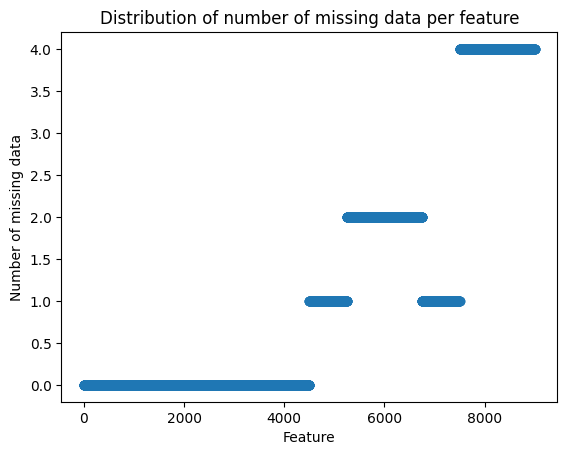

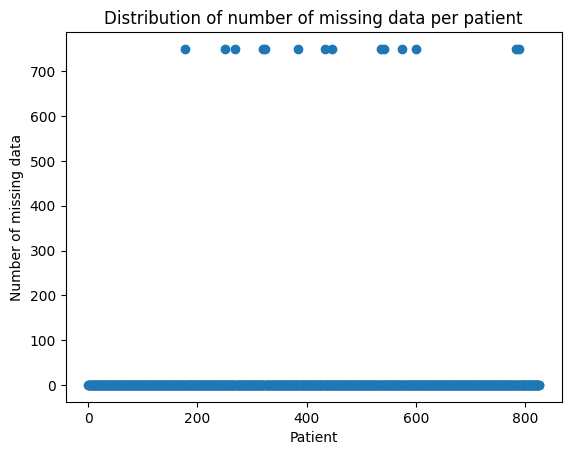

In [2]:
# exclude label column
values_features = data.drop(['label'], axis=1)

# plot the distribution of missing data per feature
num_zeros_features = (values_features == 0).sum(axis=0)
plt.scatter(range(len(num_zeros_features)),num_zeros_features)
plt.title("Distribution of number of missing data per feature")
plt.ylabel('Number of missing data')
plt.xlabel('Feature')
plt.show()

# plot the distribution of missing data per patient
num_zeros_patients=(values_features == 0).sum(axis=1)
plt.scatter(range(len(num_zeros_patients)),num_zeros_patients)
plt.title("Distribution of number of missing data per patient")
plt.ylabel('Number of missing data')
plt.xlabel('Patient')
plt.show()

### Create function 'clean_outlier'

In [3]:
def clean_outlier(dataframe):
  new_dfs = []
  for i in range(9000):
        data=dataframe[dataframe.columns[i]]
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQD = Q3 - Q1
        Upper_outlier_boundary = Q3 + (1.5 * IQD)
        Lower_outlier_boundary = Q1 - (1.5 * IQD)
        clipped_col = pd.DataFrame({dataframe.columns[i]: dataframe[dataframe.columns[i]].clip(Lower_outlier_boundary, Upper_outlier_boundary)})
        new_dfs.append(clipped_col)
  clean_outlier_data = pd.concat(new_dfs, axis=1)
  clean_outlier_data= pd.concat([clean_outlier_data,dataframe.iloc[:,-1]], axis=1)
  return clean_outlier_data

### Delete rows with missing data & clean data



In [4]:
values_data = data.drop(['label'], axis=1)
mask = (values_data != 0).all(axis=1)
clean_data_raw=data[mask]
dirty_data=data[~mask]
clean_data = clean_outlier(clean_data_raw)

### Plot number of missing data per features and per patient after data cleanup

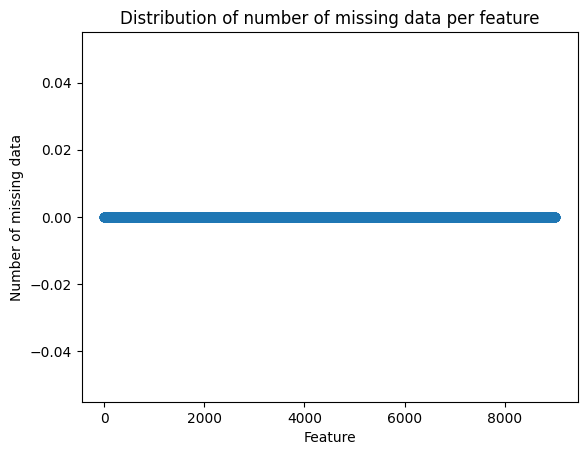

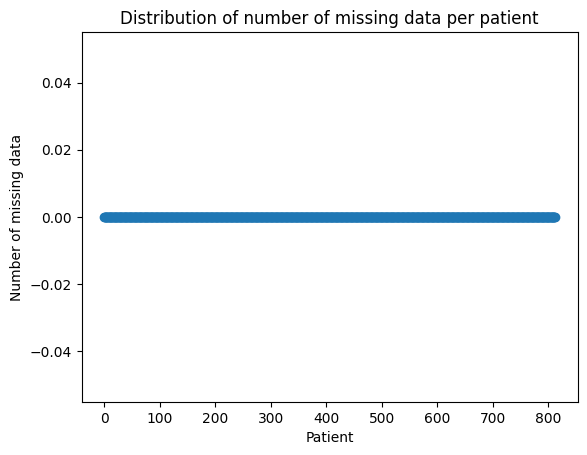

In [5]:
# exclude label column
values_clean_data = clean_data.drop(['label'], axis=1)
# plot the distribution of missing data per feature
num_zeros_features = (values_clean_data == 0).sum(axis=0)
plt.scatter(range(len(num_zeros_features)),num_zeros_features)
plt.title("Distribution of number of missing data per feature")
plt.ylabel('Number of missing data')
plt.xlabel('Feature')
plt.show()

# plot the distribution of missing data per patient
num_zeros_patients=(values_clean_data == 0).sum(axis=1)
plt.scatter(range(len(num_zeros_patients)),num_zeros_patients)
plt.title("Distribution of number of missing data per patient")
plt.ylabel('Number of missing data')
plt.xlabel('Patient')
plt.show()

### Check distribution

In [6]:
from scipy.stats import kstest
# Statistical tests for normality
ks_counter_normal = 0
ks_counter_not_normal = 0
p_values = []

for col in values_clean_data.columns:
    # Kolmogorov-Smirnov test
    p_value_ks = kstest(values_clean_data[col], 'norm')[1]
    p_values.append(p_value_ks)
    if p_value_ks > 0.05:
        print(f"{col} is normally distributed (Kolmogorov-Smirnov test p-value = {p_value_ks})")
        ks_counter_normal += 1
    else:
      ks_counter_not_normal += 1

print(f"The Kolmogorov-Smirnov test gave {ks_counter_normal} normally distributed frequencies & {ks_counter_not_normal} not normally distributed frequencies")


The Kolmogorov-Smirnov test gave 0 normally distributed frequencies & 9000 not normally distributed frequencies


## For loop cross-val train-test

In [59]:


# KNN scores
mean_accuracy_scores_knn = []
mean_precision_scores_knn  = []
mean_recall_scores_knn  = []
mean_f1_scores_knn  = []
mean_fbeta_scores_knn  = [] 

# SVM scores
mean_accuracy_scores_svm = []
mean_precision_scores_svm  = []
mean_recall_scores_svm  = []
mean_f1_scores_svm  = []
mean_fbeta_scores_svm  = [] 

# SVM Poly scores
mean_accuracy_scores_svmpoly = []
mean_precision_scores_svmpoly  = []
mean_recall_scores_svmpoly  = []
mean_f1_scores_svmpoly  = []
mean_fbeta_scores_svmpoly  = [] 

# Desicion tree scores
mean_accuracy_scores_dt = []
mean_precision_scores_dt  = []
mean_recall_scores_dt  = []
mean_f1_scores_dt  = []
mean_fbeta_scores_dt  = [] 

# Random forest scores
mean_accuracy_scores_rf = []
mean_precision_scores_rf  = []
mean_recall_scores_rf  = []
mean_f1_scores_rf  = []
mean_fbeta_scores_rf = [] 

# Linear (linear regression) classifier
mean_accuracy_scores_lr = []
mean_precision_scores_lr  = []
mean_recall_scores_lr  = []
mean_f1_scores_lr  = []
mean_fbeta_scores_lr  = [] 

# combination classifier
mean_accuracy_scores_combi = []
mean_precision_scores_combi  = []
mean_recall_scores_combi  = []
mean_f1_scores_combi  = []
mean_fbeta_scores_combi  = [] 
mean_train_scores = []
std_train_scores = []
mean_test_scores = []
std_test_scores = []

# KNN scores
knn_accuracy_test = []
knn_precision_test = []
knn_recall_test = []
knn_f1_test = []
knn_fbeta_test = []

# SVM scores
svm_accuracy_test = []
svm_precision_test = []
svm_recall_test = []
svm_f1_test = []
svm_fbeta_test = []

# SVM Poly scores
svmpoly_accuracy_test = []
svmpoly_precision_test = []
svmpoly_recall_test = []
svmpoly_f1_test = []
svmpoly_fbeta_test = []

# Desicion tree scores
dt_accuracy_test = []
dt_precision_test = []
dt_recall_test = []
dt_f1_test = []
dt_fbeta_test = []

# Random forest scores
rf_accuracy_test = []
rf_precision_test = []
rf_recall_test = []
rf_f1_test = []
rf_fbeta_test = []

# Linear (linear regression) classifier
lr_accuracy_test = []
lr_precision_test = []
lr_recall_test = []
lr_f1_test = []
lr_fbeta_test = []

# combination classifier
combi_accuracy_test = []
combi_precision_test = []
combi_recall_test = []
combi_f1_test = []
combi_fbeta_test = []

best_hyper_param_knn = []
best_hyper_param_svm = []
best_hyper_param_svmpoly = []
best_hyper_param_dt = []
best_hyper_param_rf = []
best_hyper_param_lr = []

# Learning curve - combination classifier


# Stratified to keep the balance of the classes the same in the splits
skf = StratifiedKFold(n_splits=5, random_state=30, shuffle=True)

x_forloop = clean_data.iloc[:, :-1].values
y_forloop = clean_data.iloc[:, -1].values


for fold, (train_indices, test_indices) in enumerate(skf.split(x_forloop, y_forloop)):
    train_set = clean_data.iloc[train_indices]
    test_set = clean_data.iloc[test_indices]

################################### downsampling ###############################
    # Separate abnormal and normal data in the training set
    ECG_TRAIN_ABNORMAL = train_set[train_set['label'] == 1]
    ECG_TRAIN_NORMAL = train_set[train_set['label'] == 0]

    # Downsample the normal data to balance the classes
    ECG_TRAIN_DOWNSAMPLED = resample(ECG_TRAIN_NORMAL,
                                    replace=False,
                                    n_samples=len(ECG_TRAIN_ABNORMAL),
                                    random_state=30)
    # Combine the downsampled normal data with the abnormal data
    train_set_downsampled = pd.concat([ECG_TRAIN_ABNORMAL, ECG_TRAIN_DOWNSAMPLED])

    # Shuffle the training set
    train_set_shuffled = train_set_downsampled.sample(frac=1, random_state=30)

################################### scaling ####################################
    # scaling the data between 0 and 1
    scaler = MinMaxScaler(feature_range=(0,1))
    # fit the scaler on the train set
    scaler.fit(train_set_shuffled)


    # transform both train and test data set with the scaler
    train_set_scaled = pd.DataFrame(scaler.transform(train_set_shuffled))
    train_set_scaled.columns=data.columns.values
    test_set_scaled = pd.DataFrame(scaler.transform(test_set))
    test_set_scaled.columns=data.columns.values        

################################### PCA ########################################
    x_pca_train_init = train_set_scaled.iloc[:, :-1].values
    pca = PCA(56)
    pca.fit(x_pca_train_init)


    X_pca_train = pca.transform(x_pca_train_init)
    y_pca_train = train_set_scaled.iloc[:, -1].values

    x_pca_test_init = test_set_scaled.iloc[:, :-1].values 
    X_pca_test = pca.transform(x_pca_test_init)
    y_pca_test = test_set_scaled.iloc[:, -1].values  



################################### KNN ########################################
    knn = KNeighborsClassifier(n_neighbors = 3, weights='uniform')
    knn.fit(X_pca_train,y_pca_train)

    # Compute the accuracy of the classifier
    binary_accuracy = make_scorer(accuracy_score)
    accuracy_scores = cross_val_score(knn, X_pca_train, y_pca_train, cv=skf, scoring=binary_accuracy)
    mean_accuracy_score = accuracy_scores.mean()
    mean_accuracy_scores_knn.append(mean_accuracy_score)
    #print("The mean accuracy score of the classifier is: {:.2f}".format(mean_accuracy_score))

    # Compute the precision of the classifier
    binary_precision = make_scorer(precision_score, average='binary', zero_division=0)
    precision_scores = cross_val_score(knn, X_pca_train, y_pca_train, cv=skf, scoring=binary_precision)
    mean_precision_score = precision_scores.mean()
    mean_precision_scores_knn.append(mean_precision_score)
    #print("The mean precision score of the classifier is: {:.2f}".format(mean_precision_score))

    # Compute the recall of the classifier
    binary_recall = make_scorer(recall_score, average='binary')
    recall_scores = cross_val_score(knn, X_pca_train, y_pca_train, cv=skf, scoring=binary_recall)
    mean_recall_score = recall_scores.mean()
    mean_recall_scores_knn.append(mean_recall_score)
    #print("The mean recall score of the classifier is: {:.2f}".format(mean_recall_score))

    # Compute the F1 score of the classifier
    binary_f1 = make_scorer(f1_score, average='binary')
    f1_scores = cross_val_score(knn, X_pca_train, y_pca_train, cv=skf, scoring=binary_f1)
    mean_f1_score = f1_scores.mean()
    mean_f1_scores_knn.append(mean_f1_score)
    #print("The mean F1 score of the classifier is: {:.2f}".format(mean_f1_score))

    # Compute the weighted F1 score of the classifier
    fbeta_scorer = make_scorer(fbeta_score, beta=1.732, average='binary')
    fbeta_scores = cross_val_score(knn, X_pca_train, y_pca_train, cv=skf, scoring=fbeta_scorer)
    mean_fbeta_score = fbeta_scores.mean()
    mean_fbeta_scores_knn.append(mean_fbeta_score)
    #print("The mean weighted F1 score of the classifier is: {:.2f}".format(mean_fbeta_score))
    # print("")

    
    # parameters = {'n_neighbors': [3, 5, 7, 9],'weights': ['uniform', 'distance']}
    # grid_search = GridSearchCV(knn, param_grid=parameters, cv=5, scoring=fbeta_scorer)
    # grid_search.fit(X_pca, y_pca_init)
    # best_hyper_param=grid_search.best_params_
    # best_hyper_param_knn.append(best_hyper_param)

################################### SVM RBF #####################################
    svmrbf = SVC(kernel='rbf', gamma=10, C=0.1)
    svmrbf.fit(X_pca_train,y_pca_train)

    # Compute the accuracy of the classifier
    binary_accuracy = make_scorer(accuracy_score)
    accuracy_scores = cross_val_score(svmrbf, X_pca_train, y_pca_train, cv=skf, scoring=binary_accuracy)
    mean_accuracy_score = accuracy_scores.mean()
    mean_accuracy_scores_svm.append(mean_accuracy_score)

    # Compute the precision of the classifier
    binary_precision = make_scorer(precision_score, average='binary', zero_division=0)
    precision_scores = cross_val_score(svmrbf, X_pca_train, y_pca_train, cv=skf, scoring=binary_precision)
    mean_precision_score = precision_scores.mean()
    mean_precision_scores_svm.append(mean_precision_score)

    # Compute the recall of the classifier
    binary_recall = make_scorer(recall_score, average='binary')
    recall_scores = cross_val_score(svmrbf, X_pca_train, y_pca_train, cv=skf, scoring=binary_recall)
    mean_recall_score = recall_scores.mean()
    mean_recall_scores_svm.append(mean_recall_score)

    # Compute the F1 score of the classifier
    binary_f1 = make_scorer(f1_score, average='binary')
    f1_scores = cross_val_score(svmrbf, X_pca_train, y_pca_train, cv=skf, scoring=binary_f1)
    mean_f1_score = f1_scores.mean()
    mean_f1_scores_svm.append(mean_f1_score)

    # Compute the weighted F1 score of the classifier
    fbeta_scorer = make_scorer(fbeta_score, beta=1.732, average='binary')
    fbeta_scores = cross_val_score(svmrbf, X_pca_train, y_pca_train, cv=skf, scoring=fbeta_scorer)
    mean_fbeta_score = fbeta_scores.mean()
    mean_fbeta_scores_svm.append(mean_fbeta_score)

    # param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}
    # grid_search = GridSearchCV(estimator=svmrbf, param_grid=param_grid, cv=skf, scoring=fbeta_scorer)
    # grid_search.fit(X_pca, y_pca_init)
    # best_hyper_param=grid_search.best_params_
    # best_hyper_param_svm.append(best_hyper_param)

################################### svmpoly #####################################
    svmpoly = SVC(kernel='poly', degree=1, gamma='scale', C=10)
    svmpoly.fit(X_pca_train,y_pca_train)

    # Compute the accuracy of the classifier
    binary_accuracy = make_scorer(accuracy_score)
    accuracy_scores = cross_val_score(svmpoly, X_pca_train, y_pca_train, cv=skf, scoring=binary_accuracy)
    mean_accuracy_score = accuracy_scores.mean()
    mean_accuracy_scores_svmpoly.append(mean_accuracy_score)

    # Compute the precision of the classifier
    binary_precision = make_scorer(precision_score, average='binary', zero_division=0)
    precision_scores = cross_val_score(svmpoly, X_pca_train, y_pca_train, cv=skf, scoring=binary_precision)
    mean_precision_score = precision_scores.mean()
    mean_precision_scores_svmpoly.append(mean_precision_score)

    # Compute the recall of the classifier
    binary_recall = make_scorer(recall_score, average='binary')
    recall_scores = cross_val_score(svmpoly, X_pca_train, y_pca_train, cv=skf, scoring=binary_recall)
    mean_recall_score = recall_scores.mean()
    mean_recall_scores_svmpoly.append(mean_recall_score)

    # Compute the F1 score of the classifier
    binary_f1 = make_scorer(f1_score, average='binary')
    f1_scores = cross_val_score(svmpoly, X_pca_train, y_pca_train, cv=skf, scoring=binary_f1)
    mean_f1_score = f1_scores.mean()
    mean_f1_scores_svmpoly.append(mean_f1_score)

    # Compute the weighted F1 score of the classifier
    fbeta_scorer = make_scorer(fbeta_score, beta=1.732, average='binary')
    fbeta_scores = cross_val_score(svmpoly, X_pca_train, y_pca_train, cv=skf, scoring=fbeta_scorer)
    mean_fbeta_score = fbeta_scores.mean()
    mean_fbeta_scores_svmpoly.append(mean_fbeta_score)

    # param_grid = {'C': [0.1, 1, 10], 'kernel': ['poly'], 'degree': [1, 2, 3, 4], 'gamma': ['scale', 'auto']}
    # grid_search = GridSearchCV(svmpoly, param_grid=param_grid, scoring=fbeta_scorer, cv=5)
    # grid_search.fit(X_pca, y_pca_init)
    # best_hyper_param=grid_search.best_params_
    # best_hyper_param_svmpoly.append(best_hyper_param)
################################# Decision tree ################################
    decision_tree = DecisionTreeClassifier(max_depth= 10, min_samples_leaf=4, min_samples_split=10)
    decision_tree.fit(X_pca_train,y_pca_train)

    # Compute the accuracy of the classifier
    binary_accuracy = make_scorer(accuracy_score)
    accuracy_scores = cross_val_score(decision_tree, X_pca_train, y_pca_train, cv=skf, scoring=binary_accuracy)
    mean_accuracy_score = accuracy_scores.mean()
    mean_accuracy_scores_dt.append(mean_accuracy_score)

    # Compute the precision of the classifier
    binary_precision = make_scorer(precision_score, average='binary', zero_division=0)
    precision_scores = cross_val_score(decision_tree, X_pca_train, y_pca_train, cv=skf, scoring=binary_precision)
    mean_precision_score = precision_scores.mean()
    mean_precision_scores_dt.append(mean_precision_score)

    # Compute the recall of the classifier
    binary_recall = make_scorer(recall_score, average='binary')
    recall_scores = cross_val_score(decision_tree, X_pca_train, y_pca_train, cv=skf, scoring=binary_recall)
    mean_recall_score = recall_scores.mean()
    mean_recall_scores_dt.append(mean_recall_score)

    # Compute the F1 score of the classifier
    binary_f1 = make_scorer(f1_score, average='binary')
    f1_scores = cross_val_score(decision_tree, X_pca_train, y_pca_train, cv=skf, scoring=binary_f1)
    mean_f1_score = f1_scores.mean()
    mean_f1_scores_dt.append(mean_f1_score)

    # Compute the weighted F1 score of the classifier
    fbeta_scorer = make_scorer(fbeta_score, beta=1.732, average='binary')
    fbeta_scores = cross_val_score(decision_tree, X_pca_train, y_pca_train, cv=skf, scoring=fbeta_scorer)
    mean_fbeta_score = fbeta_scores.mean()
    mean_fbeta_scores_dt.append(mean_fbeta_score)

    # params = {'max_depth': [None, 5, 10, 15, 20],
    #         'min_samples_split': [2, 5, 10, 15],
    #         'min_samples_leaf': [1, 2, 4, 8, 16]}

    # grid_search = GridSearchCV(decision_tree, param_grid=params, cv=5, scoring=fbeta_scorer)
    # grid_search.fit(X_pca, y_pca_init)
    # best_hyper_param=grid_search.best_params_
    # best_hyper_param_dt.append(best_hyper_param)

################################# Random forest ################################
    random_forest = RandomForestClassifier(max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=300)
    random_forest.fit(X_pca_train,y_pca_train)

    # Compute the accuracy of the classifier
    binary_accuracy = make_scorer(accuracy_score)
    accuracy_scores = cross_val_score(random_forest, X_pca_train, y_pca_train, cv=skf, scoring=binary_accuracy)
    mean_accuracy_score = accuracy_scores.mean()
    mean_accuracy_scores_rf.append(mean_accuracy_score)

    # Compute the precision of the classifier
    binary_precision = make_scorer(precision_score, average='binary', zero_division=0)
    precision_scores = cross_val_score(random_forest, X_pca_train, y_pca_train, cv=skf, scoring=binary_precision)
    mean_precision_score = precision_scores.mean()
    mean_precision_scores_rf.append(mean_precision_score)

    # Compute the recall of the classifier
    binary_recall = make_scorer(recall_score, average='binary')
    recall_scores = cross_val_score(random_forest, X_pca_train, y_pca_train, cv=skf, scoring=binary_recall)
    mean_recall_score = recall_scores.mean()
    mean_recall_scores_rf.append(mean_recall_score)

    # Compute the F1 score of the classifier
    binary_f1 = make_scorer(f1_score, average='binary')
    f1_scores = cross_val_score(random_forest, X_pca_train, y_pca_train, cv=skf, scoring=binary_f1)
    mean_f1_score = f1_scores.mean()
    mean_f1_scores_rf.append(mean_f1_score)

    # Compute the weighted F1 score of the classifier
    fbeta_scorer = make_scorer(fbeta_score, beta=1.732, average='binary')
    fbeta_scores = cross_val_score(random_forest, X_pca_train, y_pca_train, cv=skf, scoring=fbeta_scorer)
    mean_fbeta_score = fbeta_scores.mean()
    mean_fbeta_scores_rf.append(mean_fbeta_score)

    # params = {'n_estimators': [100, 200, 300],
    #         'max_depth': [None, 5, 10],
    #         'min_samples_split': [2, 5, 10],
    #         'min_samples_leaf': [1, 2, 4]}

    # grid_search = GridSearchCV(random_forest, param_grid=params, cv=5, scoring=fbeta_scorer)
    # grid_search.fit(X_pca, y_pca_init)
    # best_hyper_param=grid_search.best_params_
    # best_hyper_param_rf.append(best_hyper_param)

############################## Linear Regression ###############################
    linear = LogisticRegression(C=0.1, penalty='l2', max_iter=1000)
    linear.fit(X_pca_train,y_pca_train)

    # Compute the accuracy of the classifier
    binary_accuracy = make_scorer(accuracy_score)
    accuracy_scores = cross_val_score(linear, X_pca_train, y_pca_train, cv=skf, scoring=binary_accuracy)
    mean_accuracy_score = accuracy_scores.mean()
    mean_accuracy_scores_lr.append(mean_accuracy_score)

    # Compute the precision of the classifier
    binary_precision = make_scorer(precision_score, average='binary', zero_division=0)
    precision_scores = cross_val_score(linear, X_pca_train, y_pca_train, cv=skf, scoring=binary_precision)
    mean_precision_score = precision_scores.mean()
    mean_precision_scores_lr.append(mean_precision_score)

    # Compute the recall of the classifier
    binary_recall = make_scorer(recall_score, average='binary')
    recall_scores = cross_val_score(linear, X_pca_train, y_pca_train, cv=skf, scoring=binary_recall)
    mean_recall_score = recall_scores.mean()
    mean_recall_scores_lr.append(mean_recall_score)

    # Compute the F1 score of the classifier
    binary_f1 = make_scorer(f1_score, average='binary')
    f1_scores = cross_val_score(linear, X_pca_train, y_pca_train, cv=skf, scoring=binary_f1)
    mean_f1_score = f1_scores.mean()
    mean_f1_scores_lr.append(mean_f1_score)

    # Compute the weighted F1 score of the classifier
    fbeta_scorer = make_scorer(fbeta_score, beta=1.732, average='binary')
    fbeta_scores = cross_val_score(linear, X_pca_train, y_pca_train, cv=skf, scoring=fbeta_scorer)
    mean_fbeta_score = fbeta_scores.mean()
    mean_fbeta_scores_lr.append(mean_fbeta_score)

    # param_grid = {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
    # grid_search = GridSearchCV(linear, param_grid, cv=5, scoring=fbeta_scorer)
    # grid_search.fit(X_pca, y_pca_init)
    # best_hyper_param=grid_search.best_params_
    # best_hyper_param_lr.append(best_hyper_param)

################################# Combination ##################################
    # estimators = [('decision tree', decision_tree), ('svmpoly', svmpoly), ('linear', linear)]
    estimators = [('svm', svmrbf), ('random forrest', random_forest), ('linear', linear)]
    combined = VotingClassifier(estimators, voting='hard')
    combined.fit(X_pca_train,y_pca_train)

    # Compute the accuracy of the classifier
    binary_accuracy = make_scorer(accuracy_score)
    accuracy_scores = cross_val_score(combined, X_pca_train, y_pca_train, cv=skf, scoring=binary_accuracy)
    mean_accuracy_score = accuracy_scores.mean()
    mean_accuracy_scores_combi.append(mean_accuracy_score)

    # Compute the precision of the classifier
    binary_precision = make_scorer(precision_score, average='binary', zero_division=0)
    precision_scores = cross_val_score(combined, X_pca_train, y_pca_train, cv=skf, scoring=binary_precision)
    mean_precision_score = precision_scores.mean()
    mean_precision_scores_combi.append(mean_precision_score)

    # Compute the recall of the classifier
    binary_recall = make_scorer(recall_score, average='binary')
    recall_scores = cross_val_score(combined, X_pca_train, y_pca_train, cv=skf, scoring=binary_recall)
    mean_recall_score = recall_scores.mean()
    mean_recall_scores_combi.append(mean_recall_score)

    # Compute the F1 score of the classifier
    binary_f1 = make_scorer(f1_score, average='binary')
    f1_scores = cross_val_score(combined, X_pca_train, y_pca_train, cv=skf, scoring=binary_f1)
    mean_f1_score = f1_scores.mean()
    mean_f1_scores_combi.append(mean_f1_score)

    # Compute the weighted F1 score of the classifier
    fbeta_scorer = make_scorer(fbeta_score, beta=1.732, average='binary')
    fbeta_scores = cross_val_score(combined, X_pca_train, y_pca_train, cv=skf, scoring=fbeta_scorer)
    mean_fbeta_score = fbeta_scores.mean()
    mean_fbeta_scores_combi.append(mean_fbeta_score)

    # Plot the learning curve
    train_sizes, train_scores, test_scores = learning_curve(
    combined, X_pca_train, y_pca_train, cv=skf, scoring='f1_weighted', n_jobs=-1)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    mean_train_scores.append(train_scores_mean) 
    std_train_scores.append(train_scores_std)
    mean_test_scores.append(test_scores_mean)
    std_test_scores.append(test_scores_std)

    ##########################################################################################
    ################################### testset validatie ####################################
    ################################### KNN ##################################################

    y_pred = knn.predict(X_pca_test)
    
    accuracy = accuracy_score(y_pca_test, y_pred)
    precision = precision_score(y_pca_test, y_pred)
    recall = recall_score(y_pca_test, y_pred)
    f1 = f1_score(y_pca_test, y_pred)
    fbeta = fbeta_score(y_pca_test, y_pred, beta=1.732)

    knn_accuracy_test.append(accuracy)
    knn_precision_test.append(precision)
    knn_recall_test.append(recall)
    knn_f1_test.append(f1)
    knn_fbeta_test.append(fbeta)


################################### SVM RBF #####################################

    y_pred = svmrbf.predict(X_pca_test)
    
    accuracy = accuracy_score(y_pca_test, y_pred)
    precision = precision_score(y_pca_test, y_pred)
    recall = recall_score(y_pca_test, y_pred)
    f1 = f1_score(y_pca_test, y_pred)
    fbeta = fbeta_score(y_pca_test, y_pred, beta=1.732)

    svm_accuracy_test.append(accuracy)
    svm_precision_test.append(precision)
    svm_recall_test.append(recall)
    svm_f1_test.append(f1)
    svm_fbeta_test.append(fbeta)


################################### svmpoly #####################################
 
    y_pred = svmpoly.predict(X_pca_test)
    
    accuracy = accuracy_score(y_pca_test, y_pred)
    precision = precision_score(y_pca_test, y_pred)
    recall = recall_score(y_pca_test, y_pred)
    f1 = f1_score(y_pca_test, y_pred)
    fbeta = fbeta_score(y_pca_test, y_pred, beta=1.732)

    svmpoly_accuracy_test.append(accuracy)
    svmpoly_precision_test.append(precision)
    svmpoly_recall_test.append(recall)
    svmpoly_f1_test.append(f1)
    svmpoly_fbeta_test.append(fbeta)


################################# Decision tree ################################
 
    y_pred = decision_tree.predict(X_pca_test)
    
    accuracy = accuracy_score(y_pca_test, y_pred)
    precision = precision_score(y_pca_test, y_pred)
    recall = recall_score(y_pca_test, y_pred)
    f1 = f1_score(y_pca_test, y_pred)
    fbeta = fbeta_score(y_pca_test, y_pred, beta=1.732)

    dt_accuracy_test.append(accuracy)
    dt_precision_test.append(precision)
    dt_recall_test.append(recall)
    dt_f1_test.append(f1)
    dt_fbeta_test.append(fbeta)


################################# Random forest ################################

    y_pred = random_forest.predict(X_pca_test)
    
    accuracy = accuracy_score(y_pca_test, y_pred)
    precision = precision_score(y_pca_test, y_pred)
    recall = recall_score(y_pca_test, y_pred)
    f1 = f1_score(y_pca_test, y_pred)
    fbeta = fbeta_score(y_pca_test, y_pred, beta=1.732)

    rf_accuracy_test.append(accuracy)
    rf_precision_test.append(precision)
    rf_recall_test.append(recall)
    rf_f1_test.append(f1)
    rf_fbeta_test.append(fbeta)

############################## Linear Regression ###############################

    y_pred = linear.predict(X_pca_test)
    
    accuracy = accuracy_score(y_pca_test, y_pred)
    precision = precision_score(y_pca_test, y_pred)
    recall = recall_score(y_pca_test, y_pred)
    f1 = f1_score(y_pca_test, y_pred)
    fbeta = fbeta_score(y_pca_test, y_pred, beta=1.732)

    lr_accuracy_test.append(accuracy)
    lr_precision_test.append(precision)
    lr_recall_test.append(recall)
    lr_f1_test.append(f1)
    lr_fbeta_test.append(fbeta)

################################# Combination #################################

    y_pred = combined.predict(X_pca_test)
    
    accuracy = accuracy_score(y_pca_test, y_pred)
    precision = precision_score(y_pca_test, y_pred)
    recall = recall_score(y_pca_test, y_pred)
    f1 = f1_score(y_pca_test, y_pred)
    fbeta = fbeta_score(y_pca_test, y_pred, beta=1.732)

    combi_accuracy_test.append(accuracy)
    combi_precision_test.append(precision)
    combi_recall_test.append(recall)
    combi_f1_test.append(f1)
    combi_fbeta_test.append(fbeta)

################################### printing ###################################
print("KNN SCORES:")
print("The mean accuracy score of the classifier is: {:.2f}".format(np.mean(mean_accuracy_scores_knn)))
print("The mean precision score of the classifier is: {:.2f}".format(np.mean(mean_precision_scores_knn)))
print("The mean recall score of the classifier is: {:.2f}".format(np.mean(mean_recall_scores_knn)))
print("The mean f1 score of the classifier is: {:.2f}".format(np.mean(mean_f1_scores_knn)))
print("The mean weighted f1 score of the classifier is: {:.2f}".format(np.mean(mean_fbeta_scores_knn)))
print("")

print("SVM SCORES:")
print("The mean accuracy score of the classifier is: {:.2f}".format(np.mean(mean_accuracy_scores_svm)))
print("The mean precision score of the classifier is: {:.2f}".format(np.mean(mean_precision_scores_svm)))
print("The mean recall score of the classifier is: {:.2f}".format(np.mean(mean_recall_scores_svm)))
print("The mean f1 score of the classifier is: {:.2f}".format(np.mean(mean_f1_scores_svm)))
print("The mean weighted f1 score of the classifier is: {:.2f}".format(np.mean(mean_fbeta_scores_svm)))
print("")

print("SVM POLY SCORES:")
print("The mean accuracy score of the classifier is: {:.2f}".format(np.mean(mean_accuracy_scores_svmpoly)))
print("The mean precision score of the classifier is: {:.2f}".format(np.mean(mean_precision_scores_svmpoly)))
print("The mean recall score of the classifier is: {:.2f}".format(np.mean(mean_recall_scores_svmpoly)))
print("The mean f1 score of the classifier is: {:.2f}".format(np.mean(mean_f1_scores_svmpoly)))
print("The mean weighted f1 score of the classifier is: {:.2f}".format(np.mean(mean_fbeta_scores_svmpoly)))
print("")

print("DECISION TREE SCORES:")
print("The mean accuracy score of the classifier is: {:.2f}".format(np.mean(mean_accuracy_scores_dt)))
print("The mean precision score of the classifier is: {:.2f}".format(np.mean(mean_precision_scores_dt)))
print("The mean recall score of the classifier is: {:.2f}".format(np.mean(mean_recall_scores_dt)))
print("The mean f1 score of the classifier is: {:.2f}".format(np.mean(mean_f1_scores_dt)))
print("The mean weighted f1 score of the classifier is: {:.2f}".format(np.mean(mean_fbeta_scores_dt)))
print("")

print("RANDOM FOREST SCORES:")
print("The mean accuracy score of the classifier is: {:.2f}".format(np.mean(mean_accuracy_scores_rf)))
print("The mean precision score of the classifier is: {:.2f}".format(np.mean(mean_precision_scores_rf)))
print("The mean recall score of the classifier is: {:.2f}".format(np.mean(mean_recall_scores_rf)))
print("The mean f1 score of the classifier is: {:.2f}".format(np.mean(mean_f1_scores_rf)))
print("The mean weighted f1 score of the classifier is: {:.2f}".format(np.mean(mean_fbeta_scores_rf)))
print("")

print("LINEAR REGRESSION SCORES:")
print("The mean accuracy score of the classifier is: {:.2f}".format(np.mean(mean_accuracy_scores_lr)))
print("The mean precision score of the classifier is: {:.2f}".format(np.mean(mean_precision_scores_lr)))
print("The mean recall score of the classifier is: {:.2f}".format(np.mean(mean_recall_scores_lr)))
print("The mean f1 score of the classifier is: {:.2f}".format(np.mean(mean_f1_scores_lr)))
print("The mean weighted f1 score of the classifier is: {:.2f}".format(np.mean(mean_fbeta_scores_lr)))
print("")

print("COMBINATION CLASSIFIER SCORES:")
print("The mean accuracy score of the classifier is: {:.2f}".format(np.mean(mean_accuracy_scores_combi)))
print("The mean precision score of the classifier is: {:.2f}".format(np.mean(mean_precision_scores_combi)))
print("The mean recall score of the classifier is: {:.2f}".format(np.mean(mean_recall_scores_combi)))
print("The mean f1 score of the classifier is: {:.2f}".format(np.mean(mean_f1_scores_combi)))
print("The mean weighted f1 score of the classifier is: {:.2f}".format(np.mean(mean_fbeta_scores_combi)))
print("")

################################################################################
################################### printing ###################################
print("#####################")
print("TEST SET EVALUATION")
print("#####################")
print("KNN SCORES:")
print("The mean accuracy score of the classifier is: {:.2f}".format(np.mean(knn_accuracy_test)))
print("The mean precision score of the classifier is: {:.2f}".format(np.mean(knn_precision_test)))
print("The mean recall score of the classifier is: {:.2f}".format(np.mean(knn_recall_test)))
print("The mean f1 score of the classifier is: {:.2f}".format(np.mean(knn_f1_test)))
print("The mean weighted f1 score of the classifier is: {:.2f}".format(np.mean(knn_fbeta_test)))
print("")

print("SVM SCORES:")
print("The mean accuracy score of the classifier is: {:.2f}".format(np.mean(svm_accuracy_test)))
print("The mean precision score of the classifier is: {:.2f}".format(np.mean(svm_precision_test)))
print("The mean recall score of the classifier is: {:.2f}".format(np.mean(svm_recall_test)))
print("The mean f1 score of the classifier is: {:.2f}".format(np.mean(svm_f1_test)))
print("The mean weighted f1 score of the classifier is: {:.2f}".format(np.mean(svm_fbeta_test)))
print("")

print("SVM POLY SCORES:")
print("The mean accuracy score of the classifier is: {:.2f}".format(np.mean(svmpoly_accuracy_test)))
print("The mean precision score of the classifier is: {:.2f}".format(np.mean(svmpoly_precision_test)))
print("The mean recall score of the classifier is: {:.2f}".format(np.mean(svmpoly_recall_test)))
print("The mean f1 score of the classifier is: {:.2f}".format(np.mean(svmpoly_f1_test)))
print("The mean weighted f1 score of the classifier is: {:.2f}".format(np.mean(svmpoly_fbeta_test)))
print("")

print("DECISION TREE SCORES:")
print("The mean accuracy score of the classifier is: {:.2f}".format(np.mean(dt_accuracy_test)))
print("The mean precision score of the classifier is: {:.2f}".format(np.mean(dt_precision_test)))
print("The mean recall score of the classifier is: {:.2f}".format(np.mean(dt_recall_test)))
print("The mean f1 score of the classifier is: {:.2f}".format(np.mean(dt_f1_test)))
print("The mean weighted f1 score of the classifier is: {:.2f}".format(np.mean(dt_fbeta_test)))
print("")

print("RANDOM FOREST SCORES:")
print("The mean accuracy score of the classifier is: {:.2f}".format(np.mean(rf_accuracy_test)))
print("The mean precision score of the classifier is: {:.2f}".format(np.mean(rf_precision_test)))
print("The mean recall score of the classifier is: {:.2f}".format(np.mean(rf_recall_test)))
print("The mean f1 score of the classifier is: {:.2f}".format(np.mean(rf_f1_test)))
print("The mean weighted f1 score of the classifier is: {:.2f}".format(np.mean(rf_fbeta_test)))
print("")

print("LINEAR REGRESSION SCORES:")
print("The mean accuracy score of the classifier is: {:.2f}".format(np.mean(lr_accuracy_test)))
print("The mean precision score of the classifier is: {:.2f}".format(np.mean(lr_precision_test)))
print("The mean recall score of the classifier is: {:.2f}".format(np.mean(lr_recall_test)))
print("The mean f1 score of the classifier is: {:.2f}".format(np.mean(lr_f1_test)))
print("The mean weighted f1 score of the classifier is: {:.2f}".format(np.mean(lr_fbeta_test)))
print("")

print("COMBINATION CLASSIFIER SCORES:")
print("The mean accuracy score of the classifier is: {:.2f}".format(np.mean(combi_accuracy_test)))
print("The mean precision score of the classifier is: {:.2f}".format(np.mean(combi_precision_test)))
print("The mean recall score of the classifier is: {:.2f}".format(np.mean(combi_recall_test)))
print("The mean f1 score of the classifier is: {:.2f}".format(np.mean(combi_f1_test)))
print("The mean weighted f1 score of the classifier is: {:.2f}".format(np.mean(combi_fbeta_test)))
print("")


KNN SCORES:
The mean accuracy score of the classifier is: 0.60
The mean precision score of the classifier is: 0.62
The mean recall score of the classifier is: 0.54
The mean f1 score of the classifier is: 0.57
The mean weighted f1 score of the classifier is: 0.55

SVM SCORES:
The mean accuracy score of the classifier is: 0.50
The mean precision score of the classifier is: 0.44
The mean recall score of the classifier is: 0.86
The mean f1 score of the classifier is: 0.58
The mean weighted f1 score of the classifier is: 0.70

SVM POLY SCORES:
The mean accuracy score of the classifier is: 0.66
The mean precision score of the classifier is: 0.67
The mean recall score of the classifier is: 0.63
The mean f1 score of the classifier is: 0.65
The mean weighted f1 score of the classifier is: 0.64

DECISION TREE SCORES:
The mean accuracy score of the classifier is: 0.56
The mean precision score of the classifier is: 0.55
The mean recall score of the classifier is: 0.54
The mean f1 score of the clas

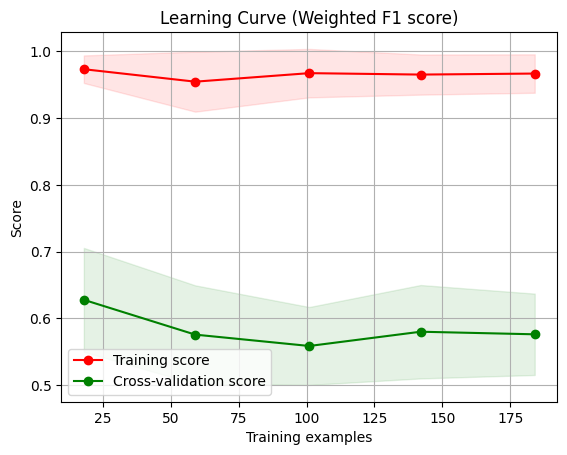

In [62]:
########################## learning curve plot #################################
mean_train_scores = np.array(mean_train_scores).mean(axis=1)
std_train_scores = np.array(std_train_scores).mean(axis=1)
mean_test_scores = np.array(mean_test_scores).mean(axis=1)
std_test_scores = np.array(std_test_scores).mean(axis=1)

plt.figure()
plt.title("Learning Curve (Weighted F1 score)")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.fill_between(train_sizes, mean_train_scores - std_train_scores,
              mean_train_scores + std_train_scores, alpha=0.1,
              color="r")
plt.fill_between(train_sizes, mean_test_scores - std_test_scores,
              mean_test_scores + std_test_scores, alpha=0.1, color="g")
plt.plot(train_sizes, mean_train_scores, 'o-', color="r",
      label="Training score")
plt.plot(train_sizes, mean_test_scores, 'o-', color="g",
      label="Cross-validation score")

plt.legend(loc="best")
plt.grid("on")
plt.show()
plt.show()
